In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [7]:
import keras
from keras import layers, optimizers
from keras.applications import vgg19
import keras.utils as utils

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [3]:
TOTAL_VAR_WT = 1e-6
STY_WT = 1e-6
CONT_WT = 2.5e-8

WIDTH, HEIGHT = 480, 480 #size of the images in the dataset

In [4]:
!git clone https://github.com/Raiden-Makoto/Genshinfy-UwU

Cloning into 'Genshinfy-UwU'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 198 (delta 45), reused 129 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (198/198), 39.67 MiB | 31.36 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [5]:
%cd Genshinfy-UwU

/content/Genshinfy-UwU


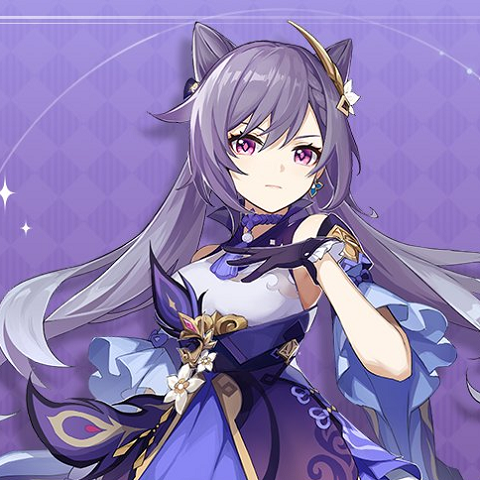

In [6]:
from IPython.display import Image, display

display(Image('./GenshinCharacters/Keqing.png'))

## Functions to Preprocess the Images

In [8]:
def preprocess_image(path):
    img = utils.load_img(path, target_size=(HEIGHT, WIDTH))
    img = utils.img_to_array(img)
    img = utils.np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [9]:
def deprocess_image(x):
    x = x.reshape((HEIGHT, WIDTH, 3))
    x[:, :, 0] += 103.939 # un-scale
    x[:, :, 1] += 116.779 # un-scale
    x[:, :, 2] += 123.68 # un-scale
    x = x[:, :, ::-1] # BGR to RGB format
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Style Transfer Loss

In [11]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [12]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = HEIGHT * WIDTH
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [13]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [14]:
def total_variation_loss(x):
    a = tf.square(x[:, :, :HEIGHT-1, :WIDTH-1] - x[:, :, 1:, :WIDTH-1])
    b = tf.square(x[:, :, :HEIGHT-1, :WIDTH-1] - x[:, :, :HEIGHT-1, 1:])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

## VGG19 Model
Uses pre-trained `imagenet` weights

In [15]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer_name = "block5_conv2"

In [17]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())

    # add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + CONT_WT * content_loss(
        base_image_features, combination_features
    )

    # add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (STY_WT / len(style_layer_names)) * sl

    # total variation loss
    loss += TOTAL_VAR_WT * total_variation_loss(combination_image)
    return loss

In [18]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## Training Loop

In [19]:
optimizer = optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)